In [3]:
slash= "\\"
import sys
# PathTomylibs-python= '/Users/s4356803/Documents/PhD/Codes/PythonCode/'
# PathToMyLibs= '/Users/s4356803/Documents/PhD/Codes/PythonCode/MyLibs-python'
PathToMyLibs= 'E:\\uqDDahl'

sys.path.append(PathToMyLibs)


In [4]:
%load_ext autoreload
%aimport MyPythonLibs.AnalysisFuncitons
%aimport MyPythonLibs.OpticalOperators
%aimport MyPythonLibs.ComplexPlotFunction
%aimport MyPythonLibs.GaussianBeamBasis
%aimport MyPythonLibs.GeneralFunctions
%aimport MyPythonLibs.SaveMaskToBinFile
%aimport MyPythonLibs.ModelabProcessBatchFile
%aimport MyPythonLibs.QuantumGateGenerator

%autoreload 1

### Imports

In [5]:
#%from ctypes import*
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, integrate, linalg, signal
digHolo = ctypes.cdll.LoadLibrary("..\\..\\bin\\Win64\\digHolo.dll")

# Below is some extra libs that are useful
import os
import scipy.io
import copy
import math
# from scipy.io import savemat loadmat
import ipywidgets
# import ComplexPlotFunction as cmplxplt
# import AnalysisFuncitons as ProCouplMat
# Global Ploting properties and style
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15,15]

import MyPythonLibs.OpticalOperators as OpticOp
import MyPythonLibs.ComplexPlotFunction as cmplxplt
import MyPythonLibs.GaussianBeamBasis as GaussBeams
import MyPythonLibs.GeneralFunctions as GenFuncs
import MyPythonLibs.AnalysisFuncitons as ProCouplMat
import MyPythonLibs.CoupMatrixAndMetricAnalysisFuncitons as MetricCals
import MyPythonLibs.SaveMaskToBinFile as SaveMaskBin
import MyPythonLibs.ModelabProcessBatchFile as Modelab
import MyPythonLibs.QuantumGateGenerator as QGateGen


# Header file like stuff that needs to be done so Python knows what all the functions are in the dll and what kind of outputs they are

In [6]:
#Get a pointer to the frame buffer.
#frameBufferPtr = frameBuffer.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
digHolo.digHoloFrameSimulatorCreateSimple.argtypes = [ctypes.c_int,ctypes.c_int,ctypes.c_int,ctypes.c_float,ctypes.c_int,ctypes.c_float,ctypes.c_int]
digHolo.digHoloFrameSimulatorCreateSimple.restype = ctypes.POINTER(ctypes.c_float)


#Redirect the console to file if desired. Useful when using the dll where
#not console is visible
digHolo.digHoloConfigSetVerbosity.argtypes = [ctypes.c_int,ctypes.c_int]
digHolo.digHoloConsoleRedirectToFile.argtypes = [ctypes.c_char_p]

#Set the basic properties of the off-axis digitial holography process.
#See digHolo.h for additional properties. Look for ConfigSet/ConfigGet
digHolo.digHoloConfigSetFramePixelSize.argtypes = [ctypes.c_int,ctypes.c_float]
digHolo.digHoloConfigSetFrameDimensions.argtypes = [ctypes.c_int,ctypes.c_int, ctypes.c_int];
digHolo.digHoloConfigSetWavelengthCentre.argtypes = [ctypes.c_int,ctypes.c_float]
digHolo.digHoloConfigSetPolCount.argtypes = [ctypes.c_int,ctypes.c_int]

digHolo.digHoloConfigSetfftWindowSizeX.argtypes = [ctypes.c_int,ctypes.c_int]
digHolo.digHoloConfigSetfftWindowSizeY.argtypes = [ctypes.c_int,ctypes.c_int]
digHolo.digHoloConfigSetIFFTResolutionMode.argtypes = [ctypes.c_int,ctypes.c_int]
#Specifies the number of HG mode groups to decompose the beams with
digHolo.digHoloConfigSetBasisGroupCount.argtypes = [ctypes.c_int,ctypes.c_int]

#Defines which parameters to optimise in the AutoAlign routine. These are on by default anyways.
digHolo.digHoloConfigSetAutoAlignBeamCentre.argtypes = [ctypes.c_int,ctypes.c_int]
digHolo.digHoloConfigSetAutoAlignDefocus.argtypes = [ctypes.c_int,ctypes.c_int]
digHolo.digHoloConfigSetAutoAlignTilt.argtypes = [ctypes.c_int,ctypes.c_int]
digHolo.digHoloConfigSetAutoAlignBasisWaist.argtypes = [ctypes.c_int,ctypes.c_int]
digHolo.digHoloConfigSetAutoAlignFourierWindowRadius.argtypes = [ctypes.c_int,ctypes.c_int]
digHolo.digHoloConfigGetAutoAlignFourierWindowRadius.argtypes = [ctypes.c_int]
digHolo.digHoloConfigGetAutoAlignFourierWindowRadius.restype = ctypes.c_int
#Setup a batch of batchCount frames, starting at the frameBufferPtr
digHolo.digHoloSetBatch.argtypes = [ctypes.c_int,ctypes.c_int]
#Run the AutoAlign routine to find parameters like beam centre, tilt, focus and waist.
digHolo.digHoloAutoAlign.argtypes = [ctypes.c_int]

digHolo.digHoloConfigGetFourierWindowRadius.argtypes = [ctypes.c_int]
digHolo.digHoloConfigGetFourierWindowRadius.restype = ctypes.c_float
digHolo.digHoloConfigSetFourierWindowRadius.argtypes = [ctypes.c_int,ctypes.c_float]


digHolo.digHoloGetFields.argtypes = [ctypes.c_int,ctypes.POINTER(ctypes.c_int),ctypes.POINTER(ctypes.c_int), 
                                     ctypes.POINTER(ctypes.POINTER(ctypes.c_float)),ctypes.POINTER(ctypes.POINTER(ctypes.c_float)),
                                     ctypes.POINTER(ctypes.c_int),ctypes.POINTER(ctypes.c_int)]
#Output return types
digHolo.digHoloGetFields.restype = ctypes.POINTER(ctypes.c_float)


digHolo.digHoloGetFourierPlaneFull.argtypes = [ctypes.c_int,ctypes.POINTER(ctypes.c_int),ctypes.POINTER(ctypes.c_int),
                                               ctypes.POINTER(ctypes.c_int),ctypes.POINTER(ctypes.c_int)]
# Output return types
digHolo.digHoloGetFourierPlaneFull.restype = ctypes.POINTER(ctypes.c_float)

#Daniel 04/09/23
#This is to see just the Fourier space window that was used.
digHolo.digHoloGetFourierPlaneWindow.argtypes = [ctypes.c_int,ctypes.POINTER(ctypes.c_int),ctypes.POINTER(ctypes.c_int),
                                               ctypes.POINTER(ctypes.c_int),ctypes.POINTER(ctypes.c_int)]
# Output return types
digHolo.digHoloGetFourierPlaneWindow.restype = ctypes.POINTER(ctypes.c_float)



# from matplotlib.colors import hsv_to_rgb
# def complex_to_rgb(Z):
#     r = np.abs(Z)
#     arg = np.angle(Z)
#     h = (arg + np.pi)  / (2 * np.pi)
#     s = np.ones(h.shape)
#     v = r  / np.amax(r)  #alpha
#     c = hsv_to_rgb(   np.moveaxis(np.array([h,s,v]) , 0, -1)  ) # --> tuple
#     return c

In [7]:
frameBuffer_int = np.load('PiFlipCal_CameraFrames_new.npy')
frameBuffer=frameBuffer_int.astype(np.float32)
frameBufferPtr = frameBuffer.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
# CamDims=frameBuffer.shape
# start_index=255*CamDims[1]*CamDims[2]
# # # c_pointer = (frameBuffer.ctypes.data + start_index * frameBuffer.itemsize).as_ctypes()
# # # c_pointer = (frameBuffer.ctypes.data + start_index * frameBuffer.itemsize)
# # # frameBufferPtr = (ctypes.c_float * (frameBuffer.size - start_index)).from_address(ctypes.addressof(c_pointer))

# # Calculate the starting memory address of the C pointer
# c_pointer = (frameBuffer.ctypes.data + start_index * frameBuffer.itemsize)
# # Create a C-compatible pointer from the calculated memory address
# frameBufferPtr = ctypes.cast(c_pointer, ctypes.POINTER(ctypes.c_float))


# # Calculate the starting memory address of the C pointer
# c_pointer = (arr.ctypes.data + start_index * arr.itemsize)
# # Create a C-compatible pointer from the calculated memory address
# c_array = ctypes.cast(c_pointer, ctypes.POINTER(ctypes.c_float))

# c_pointer = (arr.ctypes.data + start_index * arr.itemsize).as_ctypes()
# c_array = (ctypes.c_int * (arr.size - start_index)).from_address(ctypes.addressof(c_pointer))


In [ ]:
type(frameBuffer[0,0,0])

numpy.float32

In [ ]:
def PlotFrames(iframe,frames):
    fig, ax1=plt.subplots();
    # fig.subplots_adjust(wspace=0.1, hspace=-0.6);
    ax1.imshow(frames[iframe,:,:],cmap='gray');
    ax1.set_title('Poop',fontsize = 8);
    ax1.axis('off');

In [ ]:
frameCount=257
ipywidgets.interact(PlotFrames,iframe=(0,frameCount-1,1),frames=ipywidgets.fixed(frameBuffer))

interactive(children=(IntSlider(value=128, description='iframe', max=256), Output()), _dom_classes=('widget-in…

<function __main__.PlotFrames(iframe, frames)>

### Settings

In [8]:
#In this example, frame pixel data will be generated automatically.
#However commented out are examples of loading it from a .mat file
#matContents = io.loadmat('fileBufferDefault_MG09.mat')
#modes = (matContents['modes'])
#frameBuffer = modes.astype(np.float32,order='C')

#Number of camera frames
#frameCount = frameBuffer.shape[0]

#Camera pixel size (microns)
# pixelSize = 20e-6
pixelSize = 3.75e-6
# camera_frames

#Centre wavelength (nanometres)
lambda0 = 1550e-9

#Polarisation components per frame
polCount = 1

#Width/height of window to FFT on the camera. (pixels)
# nx = 512
# ny = 512

#Amount of detail to print to console. 0: Console off. 1: Basic info. 2:Debug mode. 3: You've got serious issues
verbosity = 2

#Sets the resolution mode of the reconstructed field.
#0 : Full resolution. Reconstructed field will have same pixel
#size/dimensions as the FFT window.
#1 : Low resolution. Reconstructed field will have dimension of the IFFT
#window. 
resolutionMode = 0



#Redirects stdout console to file.
consoleRedirectToFile = 1
consoleFilename = "digHoloConsole.txt"

#Viewport mode
viewportMode = 1 #1 = Camera view.

#Number of camera frames
frameCount = 1
batchCount = frameCount

#Width/height of camera frames
CamDims=frameBuffer.shape
frameWidth = CamDims[2]
frameHeight = CamDims[1]
nx = frameWidth
ny = frameHeight

#Specifies the number of HG mode groups to decompose the beams in.
#Total modes = sum(1:maxMG). maxMG=1->1 mode, maxMG=9->45 modes.
maxMG = 1

### Generate simulated frames or pass in images

Simulated frames:

In [ ]:

# frameBufferPtr = digHolo.digHoloFrameSimulatorCreateSimple(ctypes.c_int(frameCount),ctypes.c_int(frameWidth),ctypes.c_int(frameHeight),ctypes.c_float(pixelSize),ctypes.c_int(polCount),ctypes.c_float(lambda0),ctypes.c_int(1))
# frameBuffer = np.ctypeslib.as_array(frameBufferPtr,shape=(batchCount,frameHeight,frameWidth))

# with open("test_camera_frames.npy", "wb") as file:
#     np.save(file, frameBuffer)

Pass in camera frames:

In [ ]:
# # Get camera images
# frameBuffer = None

# with open("test_camera_frames.npy", "rb") as file:
#     frameBuffer = np.load(file)

# #Number of camera frames
# frameCount = frameBuffer.shape[0]
# batchCount = frameCount     # Treat this as single batch

# # Get width/height
# frameWidth = frameBuffer.shape[2]
# frameHeight = frameBuffer.shape[1]

# # Create C type array for digHolo
# frameBufferPtr = frameBuffer.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

In [9]:
handleIdx=digHolo.digHoloCreate()
print("handleIdx = %d\n"%(handleIdx))

handleIdx = 0



### Setup interface with digHolo library

In [10]:

#Redirect the console to file if desired. Useful when using the dll where
#not console is visible
if consoleRedirectToFile:
    digHolo.digHoloConfigSetVerbosity(handleIdx,verbosity)
    charPtr = ctypes.c_char_p(consoleFilename.encode('utf-8'))
    digHolo.digHoloConsoleRedirectToFile(charPtr)

#Set the basic properties of the off-axis digitial holography process.
#See digHolo.h for additional properties. Look for ConfigSet/ConfigGet
digHolo.digHoloConfigSetFramePixelSize(handleIdx,pixelSize)
digHolo.digHoloConfigSetFrameDimensions(handleIdx,frameWidth,frameHeight);
digHolo.digHoloConfigSetWavelengthCentre(handleIdx,lambda0)

digHolo.digHoloConfigSetPolCount(handleIdx,polCount);
digHolo.digHoloConfigSetfftWindowSizeX(handleIdx,nx)
digHolo.digHoloConfigSetfftWindowSizeY(handleIdx,ny)
digHolo.digHoloConfigSetIFFTResolutionMode(handleIdx,resolutionMode)
#Specifies the number of HG mode groups to decompose the beams with
digHolo.digHoloConfigSetBasisGroupCount(handleIdx,maxMG)

#Defines which parameters to optimise in the AutoAlign routine. These are on by default anyways
digHolo.digHoloConfigSetAutoAlignBeamCentre(handleIdx,1)
digHolo.digHoloConfigSetAutoAlignDefocus(handleIdx,1)
digHolo.digHoloConfigSetAutoAlignTilt(handleIdx,1)
digHolo.digHoloConfigSetAutoAlignBasisWaist(handleIdx,1)

# Lets not do a auto align on the WindowRadius
digHolo.digHoloConfigSetAutoAlignFourierWindowRadius(handleIdx,0);
#We are going to set the WindowRadius manually
FFTRadius=digHolo.digHoloConfigSetFourierWindowRadius(handleIdx,0.2)
FFTRadius=digHolo.digHoloConfigGetFourierWindowRadius(handleIdx)

#Setup a batch of batchCount frames, starting at the frameBufferPtr
digHolo.digHoloSetBatch(handleIdx,batchCount,frameBufferPtr)
#Run the AutoAlign routine to find parameters like beam centre, tilt, focus and waist.
digHolo.digHoloAutoAlign(handleIdx)
FFTRadius=digHolo.digHoloConfigGetFourierWindowRadius(handleIdx)
print(FFTRadius)

0.20000000298023224


In [11]:
# FFTRadius=digHolo.digHoloConfigSetFourierWindowRadius(handleIdx,0.1)
# FFTRadius=digHolo.digHoloConfigGetFourierWindowRadius(handleIdx)
# print(FFTRadius)
# digHolo.digHoloConfigSetAutoAlignFourierWindowRadius(handleIdx,0);
# test=digHolo.digHoloConfigGetAutoAlignFourierWindowRadius(handleIdx,0);
# print(test)
# digHolo.digHoloAutoAlign(handleIdx)
# FFTRadius=digHolo.digHoloConfigGetFourierWindowRadius(handleIdx)
# print(FFTRadius)

# test=digHolo.digHoloConfigGetAutoAlignFourierWindowRadius(handleIdx,0);
# print(test)

In [ ]:
# FFTRadius=digHolo.digHoloConfigSetFourierWindowRadius(handleIdx,0.1)
# FFTRadius=digHolo.digHoloConfigGetFourierWindowRadius(handleIdx)
# print(FFTRadius)

# Pointers to the Reconstructed Fields and Fourier planes and windows After the AutoAlgin Routine

In [ ]:
#Get the resulting fields (digHoloGetFields)
#void digHoloGetFields(int handleIdx, int* batchCount, int* polCount, short** fieldR, short** fieldI, float** fieldScale, float** x, float** y, int* width, int* height);
#Setup pointers to the input/output parameters of the function.
#The function returns the batchCount (number of fields) and the polCount
#(number of polarisation components per field).
batchCount = ((ctypes.c_int))()
polCount = ((ctypes.c_int))()

# Get reconstructed fields

#The x/y axis of the field. Corresponding with the dimension in the camera
#plane.
xPtr = (ctypes.POINTER(ctypes.c_float))()
yPtr = (ctypes.POINTER(ctypes.c_float))()
#The width/height of the x and y axes respectively.
w = ((ctypes.c_int))()
h =((ctypes.c_int))()

ptrOut = digHolo.digHoloGetFields(handleIdx,ctypes.byref(batchCount),ctypes.byref(polCount),ctypes.byref(xPtr),ctypes.byref(yPtr),ctypes.byref(w),ctypes.byref(h))#calllib('digHolo','digHoloGetFields',handleIdx,batchCountPtr,polCountPtr,fieldRPtr, fieldIPtr,fieldScalePtr,xPtr,yPtr,wPtr,hPtr);

print(w)
# Get Fourier planes

batchCount = ((ctypes.c_int))()
polCount = ((ctypes.c_int))()

# Width and height of the Fourier plane
FourierWidth = ((ctypes.c_int))()
FourierHeight = ((ctypes.c_int))()
FourierWidth_Window = ((ctypes.c_int))()
FourierHeight_Window = ((ctypes.c_int))()


FourierPtrOut = digHolo.digHoloGetFourierPlaneFull(handleIdx, ctypes.byref(batchCount), ctypes.byref(polCount), ctypes.byref(FourierWidth), ctypes.byref(FourierHeight))

FourierPtrOut_Window = digHolo.digHoloGetFourierPlaneWindow(handleIdx, ctypes.byref(batchCount), ctypes.byref(polCount), ctypes.byref(FourierWidth_Window), ctypes.byref(FourierHeight_Window))

#The number of camera frames in the batch returned by digHoloGetFields
batchCount = np.int32(batchCount)
#The number of polarisation components per frame (batch element)
polCount = np.int32(polCount)
#The width/height of the reconstructed field per polarisation
w = np.int32(w)
h = np.int32(h)
# The width/height of the Fourier planes
FourierHeight = np.int32(FourierHeight)
FourierWidth = np.int32(FourierHeight)

FourierWidth_Window = np.int32(FourierWidth_Window)
FourierHeight_Window = np.int32(FourierHeight_Window)

c_long(1280)


# Lets look at get the Field Fourier Window and the Full Fourier plane
### You need to becarful here as there are some dimensional stuff that you need to watch for especially with the full fourier plane stuff. It is explained in documentation of digholo but is also worth looking at documentation of fftw3 documentation as that is what is actually doing the fft 

In [ ]:

###### Field
fields = np.ctypeslib.as_array(ptrOut,shape=(batchCount,polCount,w,h*2))
fields = fields[:,:,:,0::2]+1j*fields[:,:,:,1::2]
print("fields shape", fields.shape)

###### Full Fourier Plane
FourierPlanes = np.ctypeslib.as_array(FourierPtrOut,shape=(batchCount,polCount,FourierHeight,((FourierWidth//2)+1)*2))
FourierPlanes = FourierPlanes[:,:,:,0::2]+1j*FourierPlanes[:,:,:,1::2]
print("Full Fourier Planes shape", FourierPlanes.shape)

###### Fourier Window
FourierPlanes_Window = np.ctypeslib.as_array(FourierPtrOut_Window,shape=(batchCount,polCount,FourierWidth_Window,FourierHeight_Window*2))
# print(FourierPlanes_Window.shape)
FourierPlanes_Window=FourierPlanes_Window[:,:,:,0::2]+1j*FourierPlanes_Window[:,:,:,1::2]
print("Fourier Window shape",FourierPlanes_Window.shape)


fields shape (1, 1, 1280, 960)
Full Fourier Planes shape (1, 1, 960, 481)
Fourier Window shape (1, 1, 1280, 960)


### Plot reconstructed fields

In [ ]:
# This function is needed for to Plot the Camera frame Field and Full Fourier Plane and the Fourier Window
def Plot_Cam_Field_FouierPlane_FouirerWindow(imode,ipol,frameBuffer,fields,FourierPlanes,FourierPlanes_Window):
    frame = frameBuffer[imode,:,:]
    field = np.squeeze(fields[imode,ipol,:,:])
    fourierPlane=np.squeeze(FourierPlanes[imode,ipol,:,:])
    fourierWindow=np.squeeze(FourierPlanes_Window[imode,ipol,:,:])
    textSize=16
    fig, ax1=plt.subplots(2,2);
    fig.subplots_adjust(wspace=0.1, hspace=0.1);
    # ax1[0][0].subplot(2,4,1)
    ax1[0][0].imshow(frame,cmap='gray');
    ax1[0][0].set_title('Cam Image',fontsize = textSize);
    ax1[0][0].axis('off')
    ax1[0][1].imshow(cmplxplt.ComplexArrayToRgb(field));
    ax1[0][1].set_title('Field',fontsize = textSize);
    ax1[0][1].axis('off')
    # ax1[1][0].imshow(cmplxplt.ComplexArrayToRgb(fourierPlane));
    ax1[1][0].imshow(np.log(np.abs(fourierPlane)));
    ax1[1][0].set_title('Full Fourier Plane',fontsize = textSize);
    ax1[1][0].axis('off')
    ax1[1][1].imshow(cmplxplt.ComplexArrayToRgb(fourierWindow));
    ax1[1][1].set_title('Fourier Window',fontsize = textSize);
    ax1[1][1].axis('off')
    
modeCount=frameCount
ipywidgets.interact(Plot_Cam_Field_FouierPlane_FouirerWindow,imode=(0,modeCount-1,1),ipol=ipywidgets.fixed(0),frameBuffer=ipywidgets.fixed(frameBuffer),fields=ipywidgets.fixed(fields),FourierPlanes=ipywidgets.fixed(FourierPlanes),FourierPlanes_Window=ipywidgets.fixed(FourierPlanes_Window))


interactive(children=(IntSlider(value=0, description='imode', max=0), Output()), _dom_classes=('widget-interac…

<function __main__.Plot_Cam_Field_FouierPlane_FouirerWindow(imode, ipol, frameBuffer, fields, FourierPlanes, FourierPlanes_Window)>

# Lets use the viewport function for digholo

Text(0.5, 1.0, "b'Total Power (dB) : 79.44\\t(H: 79.44 V: -inf)'")

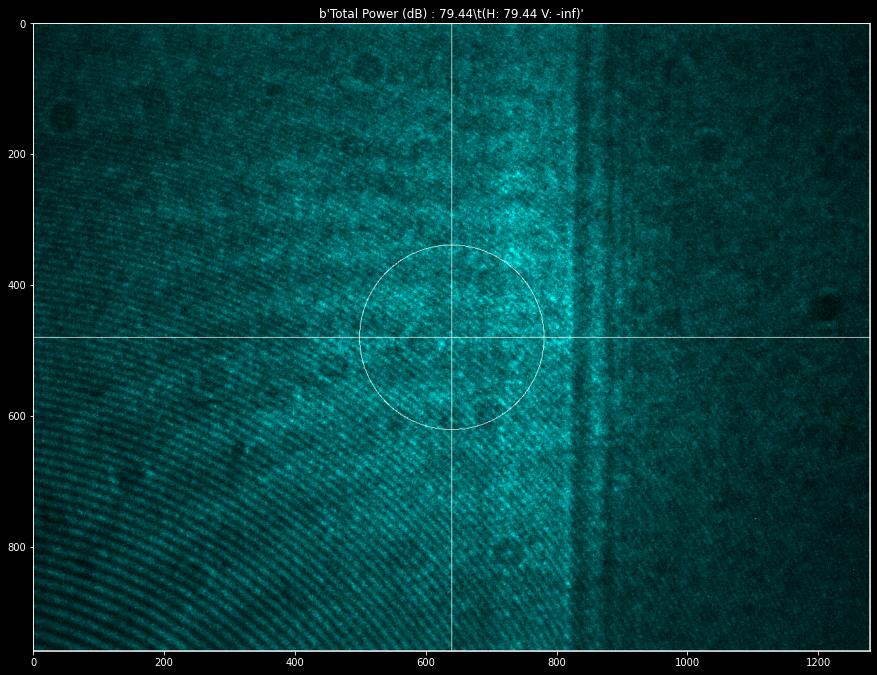

In [12]:
# digHoloGetViewportToFile (int    handleIdx, int    displayMode, int    forceProcessing, 
# int *    width, int *    height, char **    windowString) 
#displayMode=['paused','raw_camera','FFT','FFT_window','IFFT','mode_reconstruction','routine_check']
#displayMode=    0           1        2      3           4           5                   6
displayMode=1
windowString = ((ctypes.c_char_p))()
ViewPortHeight=ctypes.c_int(0)
ViewPortWidth=ctypes.c_int(0)
ViewPortPtr=ctypes.c_char_p()# this is were the output is 

# filename="Test"
# charPtr = ctypes.c_char_p(filename.encode('utf-8'))

digHolo.digHoloGetViewport.argtypes = [ctypes.c_int,ctypes.c_int,ctypes.c_int,ctypes.POINTER(ctypes.c_int),ctypes.POINTER(ctypes.c_int),ctypes.POINTER(ctypes.c_char_p)]
digHolo.digHoloGetViewport.restype = ctypes.POINTER(ctypes.c_ubyte)
ViewPortPtr=digHolo.digHoloGetViewport(handleIdx, displayMode, 0,ctypes.byref(ViewPortWidth),ctypes.byref(ViewPortHeight),ctypes.byref(windowString))
ViewPortWidth = np.int32(ViewPortWidth)
ViewPortHeight = np.int32(ViewPortHeight)
ViewPortRGB = np.ctypeslib.as_array(ViewPortPtr,shape=(ViewPortHeight,ViewPortWidth,3))
plt.figure()
plt.imshow(ViewPortRGB)
plt.title(windowString.value)


In [ ]:
%aimport  digholoCombinedFunction


In [ ]:
import digholoCombinedFunction as mydigholoFunc
import cv2
frameBufferPtr = frameBuffer.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
frameCount = ((ctypes.c_int))()
frameCount = 1
# batchCount = frameCount
batchCount = ((ctypes.c_int))()
batchCount=frameCount

mydigholoFunc.updateFields_FFT(handleIdx,batchCount,frameBufferPtr)



1


In [ ]:
Fullimage=mydigholoFunc.GetViewport_arr(handleIdx)
windowName='digholoviewport'
# Create a resizable window
cv2.namedWindow(windowName, cv2.WINDOW_NORMAL)
# Set the window to full screen (optional)
# cv2.setWindowProperty('Resizable Window', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

# Resize the window to your desired size (width, height)
cv2.resizeWindow(windowName, 800, 600)  # Change the width and height as needed
Fullimage_rgb = cv2.cvtColor(Fullimage, cv2.COLOR_BGR2RGB)# this is to get the correct colour for opencv matplotlib doesnt have this problem
cv2.imshow(windowName, Fullimage_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
digHolo.digHoloConfigSetBatchCount .argtypes=[ctypes.c_int,ctypes.c_int]
digHolo.digHoloConfigGetBatchCount.argtypes=[ctypes.c_int]
digHolo.digHoloConfigGetBatchCount.restype = ctypes.c_int
digHolo.digHoloProcessBatch.argtypes = [ctypes.c_int,ctypes.POINTER(ctypes.c_int),ctypes.POINTER(ctypes.c_int),
                                               ctypes.POINTER(ctypes.c_int)]
# Output return types
digHolo.digHoloProcessBatch.restype = ctypes.POINTER(ctypes.c_float)
# complex64 * digHoloProcessBatch (int    handleIdx, int *    batchCount, int *   
# modeCount, int *    polCount)


In [ ]:

digHolo.digHoloConfigSetBatchCount(handleIdx,batchCount)
batchcountCheck=digHolo.digHoloConfigGetBatchCount(handleIdx)

In [ ]:
batchcountCheck

256

In [ ]:
digHolo.digHoloSetBatch(handleIdx,batchCount,frameBufferPtr)
batchcountCheck=digHolo.digHoloConfigGetBatchCount(handleIdx)
print(batchcountCheck)
# batchCount = ((ctypes.c_int))()
polCount = ((ctypes.c_int))()
w = ((ctypes.c_int))()
h =((ctypes.c_int))()
batchCount = ((ctypes.c_int))()
polCount = ((ctypes.c_int))()
modeCount =((ctypes.c_int))()
# Width and height of the Fourier plane
FourierWidth = ((ctypes.c_int))()
FourierHeight = ((ctypes.c_int))()
FourierWidth_Window = ((ctypes.c_int))()
FourierHeight_Window = ((ctypes.c_int))()
ptr_temp=digHolo.digHoloProcessBatch(handleIdx,ctypes.byref(batchCount),ctypes.byref(modeCount),ctypes.byref(polCount))
ptrOut = digHolo.digHoloGetFields(handleIdx,ctypes.byref(batchCount),ctypes.byref(polCount),ctypes.byref(xPtr),ctypes.byref(yPtr),ctypes.byref(w),ctypes.byref(h))#calllib('digHolo','digHoloGetFields',handleIdx,batchCountPtr,polCountPtr,fieldRPtr, fieldIPtr,fieldScalePtr,xPtr,yPtr,wPtr,hPtr);
FourierPtrOut = digHolo.digHoloGetFourierPlaneFull(handleIdx, ctypes.byref(batchCount), ctypes.byref(polCount), ctypes.byref(FourierWidth), ctypes.byref(FourierHeight))
FourierPtrOut_Window = digHolo.digHoloGetFourierPlaneWindow(handleIdx, ctypes.byref(batchCount), ctypes.byref(polCount), ctypes.byref(FourierWidth_Window), ctypes.byref(FourierHeight_Window))
batchcountCheck=digHolo.digHoloConfigGetBatchCount(handleIdx)
print(batchcountCheck)

256


256


In [ ]:
batchCount

c_long(256)

In [ ]:

#The number of camera frames in the batch returned by digHoloGetFields
batchCount = np.int32(batchCount)
#The number of polarisation components per frame (batch element)
polCount = np.int32(polCount)
#The width/height of the reconstructed field per polarisation
w = np.int32(w)
h = np.int32(h)
# The width/height of the Fourier planes
FourierHeight = np.int32(FourierHeight)
FourierWidth = np.int32(FourierHeight)

FourierWidth_Window = np.int32(FourierWidth_Window)
FourierHeight_Window = np.int32(FourierHeight_Window)
###### Field
fields = np.ctypeslib.as_array(ptrOut,shape=(batchCount,polCount,w,h*2))
fields = fields[:,:,:,0::2]+1j*fields[:,:,:,1::2]
print("fields shape", fields.shape)

###### Full Fourier Plane
FourierPlanes = np.ctypeslib.as_array(FourierPtrOut,shape=(batchCount,polCount,FourierHeight,((FourierWidth//2)+1)*2))
FourierPlanes = FourierPlanes[:,:,:,0::2]+1j*FourierPlanes[:,:,:,1::2]
print("Full Fourier Planes shape", FourierPlanes.shape)

###### Fourier Window
FourierPlanes_Window = np.ctypeslib.as_array(FourierPtrOut_Window,shape=(batchCount,polCount,FourierWidth_Window,FourierHeight_Window*2))
# print(FourierPlanes_Window.shape)
FourierPlanes_Window=FourierPlanes_Window[:,:,:,0::2]+1j*FourierPlanes_Window[:,:,:,1::2]
print("Fourier Window shape",FourierPlanes_Window.shape)

fields shape (256, 1, 1280, 960)
Full Fourier Planes shape (256, 1, 960, 481)
Fourier Window shape (256, 1, 1280, 960)


In [ ]:
modeCount=frameCount
ipywidgets.interact(Plot_Cam_Field_FouierPlane_FouirerWindow,imode=(0,modeCount-1,1),ipol=ipywidgets.fixed(0),frameBuffer=ipywidgets.fixed(frameBuffer),fields=ipywidgets.fixed(fields),FourierPlanes=ipywidgets.fixed(FourierPlanes),FourierPlanes_Window=ipywidgets.fixed(FourierPlanes_Window))


interactive(children=(IntSlider(value=127, description='imode', max=255), Output()), _dom_classes=('widget-int…

<function __main__.Plot_Cam_Field_FouierPlane_FouirerWindow(imode, ipol, frameBuffer, fields, FourierPlanes, FourierPlanes_Window)>